# Introduction

In last years, Machine Learning made important breakthrough. In this domain, the convolution is highly used to detect features on image. But convolutions are not used only in ML but also a lot in post processing for images. This step is often slow and requires important ressources. I recently discovered that there is ways to significantly increase the perfomance with Filter's decomposition from <a href="https://www.youtube.com/watch?v=vNG3ZAd8wCc">this video</a>. In this notebook we will do a benchmark with Gaussian filters then apply this method on a filter well known of photographs called Bokeh Filter.

The code is based on <a href="https://github.com/mikepound/convolve">this repository</a> but I tried to simplify it first to understand it and make it understandable.

# What is convolution

I already used several time the convolution in previous projects but for this one, there is a need to explain it briefly. 

Given an image of $ H $ x $ W $ x $ L $ with $ L = 1 $ for a Black & White image or $ L = 3 $ for a color image and a filter of $ N $ x $ M $ x $ K $ with often $ K = 1 $, the convolution step consist of computing for each pixel of the image the sum of the value of pixel around this given pixel by the value of the filter. This is more clear on the 2 images below :

<img src="convolution.gif"/>
<img src="conv2.png"/>

So as you can imagine, the complexity of this process is $ O(n^2) $ based on the size of the image and $ O(n^2) $ also based on the filter size. The objective of the filter decomposition is to reduce the complexity of this process for the filter from $ O(n^2) $ to $ O(n) $

# Principle

If we consider a <b>square</b> filter ($ F $) of size $ N $, the process should multiply for each pixel $ N^2 $ elements. if we are able to decompose the filter as a product of vector ($ V1 $ and $ V2 $) :

$$ F_{NxN} = V1_{Nx1} \times V2_{1xN} $$

or even better if V1 = V2 (named $ V $)

$$ F_{NxN} = V_{Nx1} \times V_{Nx1}.T $$

In that case, we can apply the first convolution $ f $ with 1 vector (complexity of O(n) as our filter of size N requires N multiplication) then apply a second convolution $ g $ with the second filter on the result of the first convolution. This is possible because the convolution is an application having a commutative product so :

$$ filtered\_image = g(f(image)) = f(g(image)) $$

Now let's apply if on an easy decomposable filter which is Gaussian filter and then we will do it for a more complex one

# Common function / imports

In [1]:
import time

import numpy as np
import scipy.signal
from scipy.stats import entropy
from PIL import Image

import matplotlib.pyplot as plt

In [2]:
def read_image(path, resize_factor=1.0):
    ''' read an image from disk to numpy float32 array '''
    img = Image.open(path)
    h, w = img.size
    img = img.resize((int(h * resize_factor), int(w * resize_factor)), resample=Image.LANCZOS)
    arr = np.array(img)
    return arr / 255.0

# Reverse helper function to write an image from a numpy array
def write_image(img, path):
    ''' write a numpy float32 array to an image from disk '''
    img *= 255
    img = img.astype(np.uint8)
    Image.fromarray(img).save(path)
    
def print_image(img, title = None, figsize = (20,12)):
    ''' plot a numpy float32 array as an image '''
    plt.figure(figsize = figsize)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.show()

# Gaussian Filters

## Creation of filter

The gaussian filter is a filter often used to filter the noise on an image. This filter is quite simple to test is 1D or 2D due to his equation:

$$ G(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

if we do a convolution product between 2 gaussian, the result is also a gaussian:

$$ G(x, \mu1, \sigma1) \times G(x, \mu2, \sigma2) = G(x, \mu1 + \mu2, \sqrt{\sigma1^2 + \sigma2^2)}$$

As a result, if our filter has a $ \mu = 0 $ and the same $ \sigma $

$$ G(x, 0, \sigma) \times G(x, 0, \sigma) = G(x, 0, \sigma\sqrt{2})$$

Now, let's create both filters

In [3]:
def gaussian_kernel_2d(sigma):
    '''Produces a 2D gaussian kernel of standard deviation sigma and size 2*sigma+1'''
    kernel_radius = np.ceil(sigma) * 3
    kernel_size = kernel_radius * 2 + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1., dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

def gaussian_kernel_1d(sigma):
    '''Produces a 1D gaussian kernel of standard deviation sigma and size 2*sigma+1'''
    kernel_radius = np.ceil(sigma) * 3
    kernel_size = kernel_radius * 2 + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1., dtype=np.float32).reshape(1, -1)
    kernel = np.exp(-(ax**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

To compare the result, we will benchmark the time spent with the 2D filter and the 1D filter. Both resulting images will be stored in variation $ output $ and $ output2 $ for comparison.

In [4]:
img = read_image("M35.jpg")
output = np.zeros(img.shape, dtype=np.float32)
output2 = np.zeros(img.shape, dtype=np.float32)
sigma = 3
radius = 50

kernel_2d = gaussian_kernel_2d(sigma)
kernel_1d = gaussian_kernel_1d(sigma)

## Comparison results

First let's visualize the 2D filter (row1) and the 1D (with his product) on the row 2. The difference between both filter is printed in the last plot of the row 1 (=0 as expected)

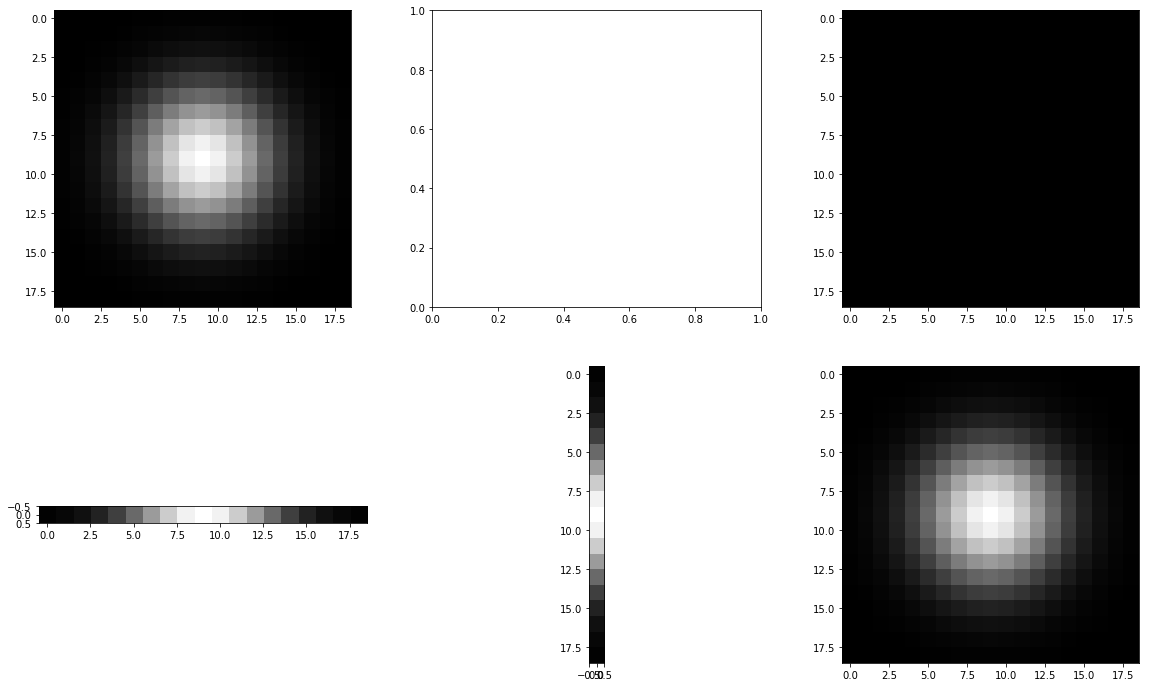

In [5]:
cbar_max = kernel_2d.max()
f, arr = plt.subplots(2,3, figsize=(20,12))
arr[0, 0].imshow(kernel_2d, cmap='gray', interpolation='nearest', vmin=0, vmax=cbar_max)
arr[1, 0].imshow(kernel_1d, cmap='gray', interpolation='nearest', vmin=0, vmax=cbar_max**0.5)  # square root as we do a multiplaction afterward
arr[1, 1].imshow(kernel_1d.T, cmap='gray', interpolation='nearest', vmin=0, vmax=cbar_max**0.5)# square root as we do a multiplaction afterward
arr[1, 2].imshow(np.dot(kernel_1d.T, kernel_1d), cmap='gray', interpolation='nearest', vmin=0, vmax=cbar_max)
arr[0, 2].imshow(kernel_2d - np.dot(kernel_1d.T, kernel_1d), cmap='gray', interpolation='nearest', vmin=0, vmax=cbar_max)
plt.show()

Now, let's compute both convolution and time them. The result is shown below

Elapsed: 6.573s
Elapsed: 1.308s


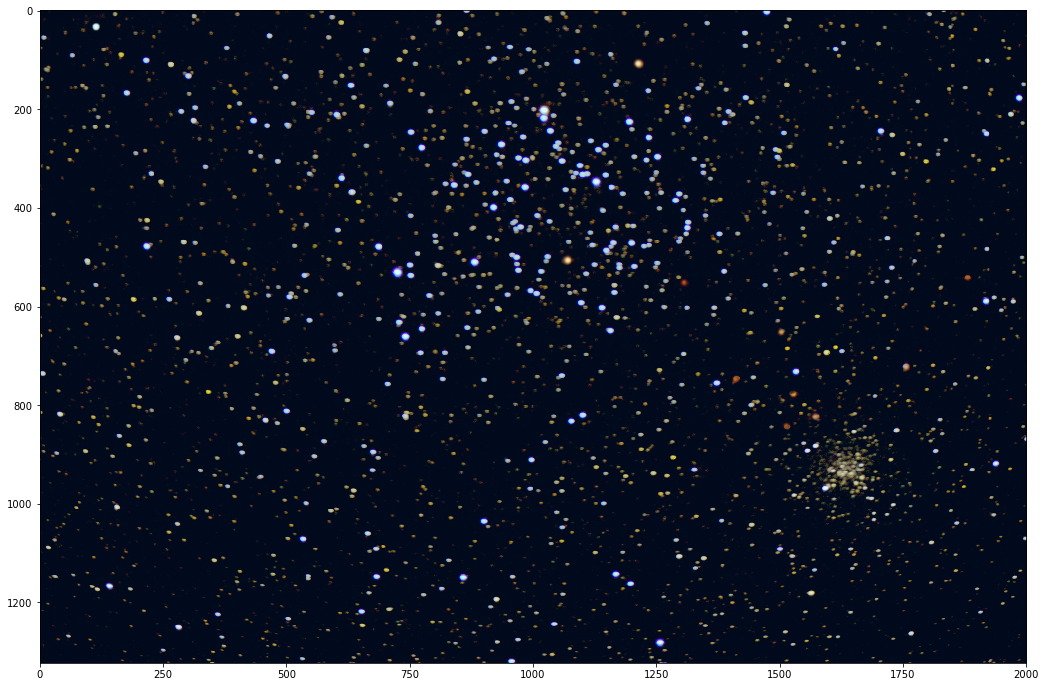

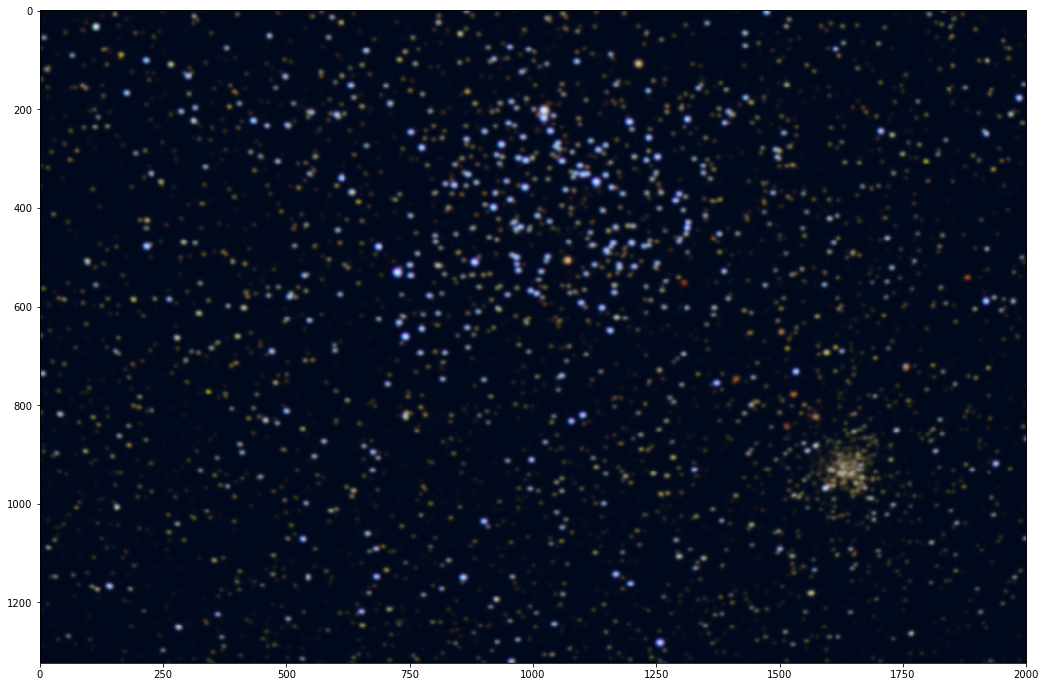

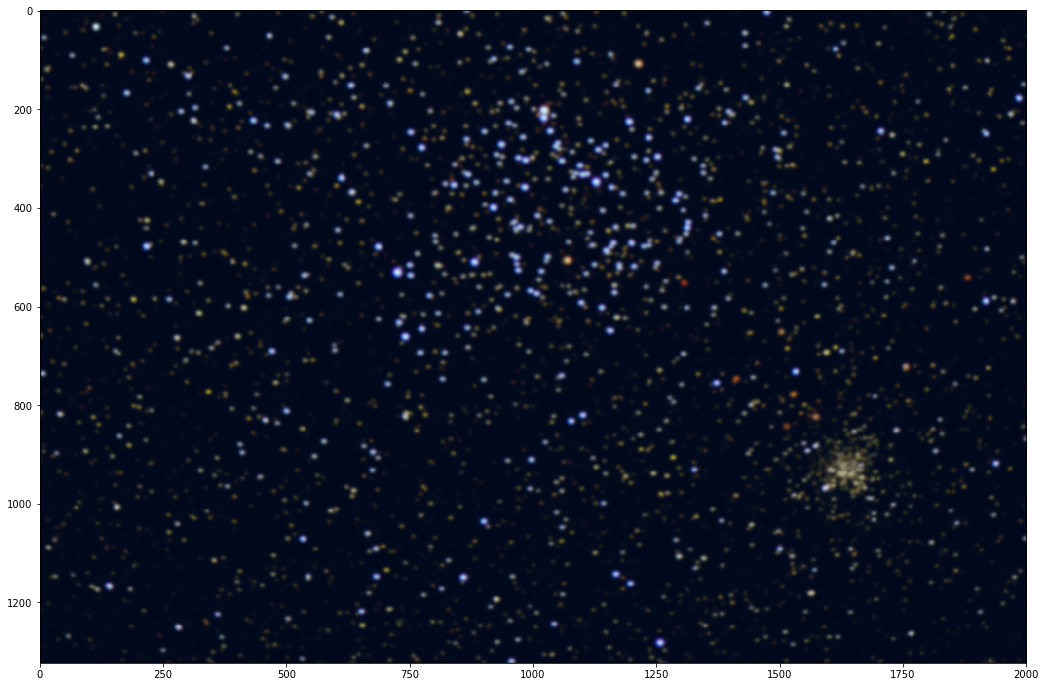

In [6]:
t0 = time.perf_counter()

# NxN convolution
for i in range(3):
    output[:, :, i] = scipy.signal.convolve2d(img[:, :, i], kernel_2d, mode="same")

t1 = time.perf_counter()
print ("Elapsed: {0:.3f}s".format(t1-t0))

# Nx1 -> 1xN convolution
for i in range(3):
    output2[:, :, i] = scipy.signal.convolve2d(img[:, :, i], kernel_1d, mode="same")

for i in range(3):
    output2[:, :, i] = scipy.signal.convolve2d(output2[:, :, i], kernel_1d.T, mode="same")

t2 = time.perf_counter()
print ("Elapsed: {0:.3f}s".format(t2-t1))

print_image(img)
print_image(output)
print_image(output2)

1.3 s instead of 6.3 second for the same image. They seems similar but let's plot an histogram of differences between pixels

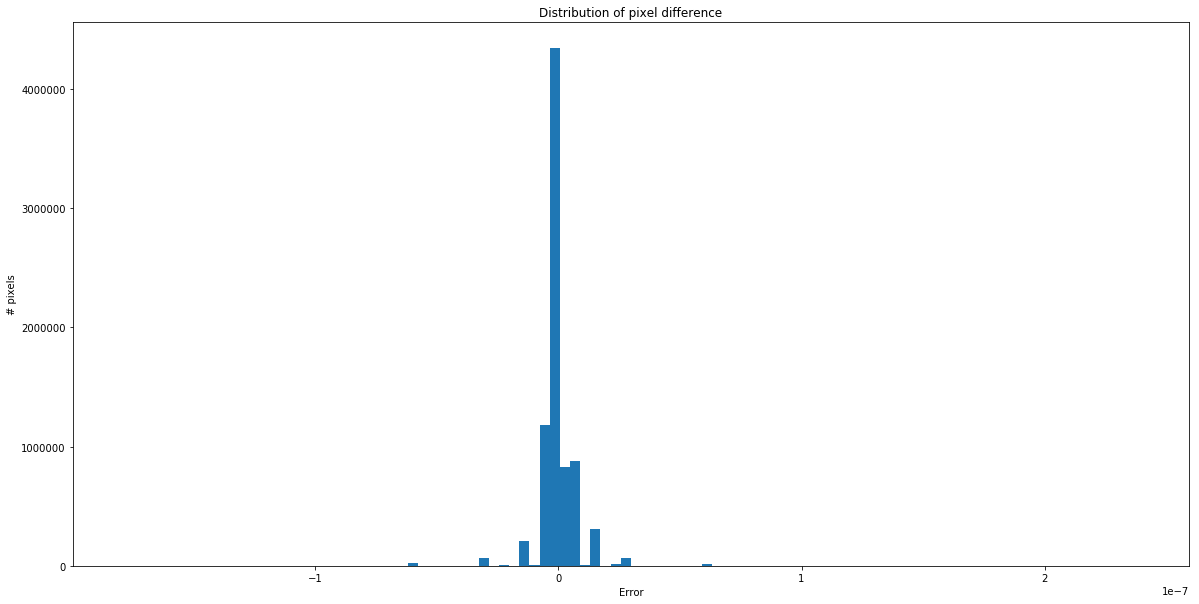

In [7]:
plt.figure(figsize=(20, 10))
plt.hist(output.flatten() - output2.flatten(), bins=100)
plt.title("Distribution of pixel difference")
plt.ylabel("# pixels")
plt.xlabel("Error")
plt.show()

The max diffeence between 2 pixel is at around 5e-8 (on a scale of 0<->1)... This means that both images are identicals. 

Another approach to check the difference is to look at entropy between images. As the value cannot be understood as is, we have to compare it to another value. To do so, let's compute the entropy between each filtered image and the initial image. 

In [24]:
e1 = entropy(img.flatten(), output.flatten())
e2 = entropy(img.flatten(), output2.flatten())
e3 = entropy(output.flatten(), output2.flatten())
print("The entropy between the image and the filtered image using the 2D filter is {} \
      \nThe entropy between the image and the filtered image using the 1D filter is {} \
      \nThe entropy between both filtered images is {}".format(e1, e2, e3))

The entropy between the image and the filtered image using the 2D filter is 0.09378802873647077       
The entropy between the image and the filtered image using the 1D filter is 0.09378803355846398       
The entropy between both filtered images is 6.875838565179038e-09


And we can see that the 2 images are really quite close...

Now, we saw that the time is around 5 times faster but we wanted to check is the complexity is now linear so let's have a look at that.

## Benchmark

### Complexity related to the Kernel Size

Let's modify the previous code to have a function which return both times

In [37]:
def bench(img):
    output = np.zeros(img.shape, dtype=np.float32)
    output2 = np.zeros(img.shape, dtype=np.float32)
    
    t0 = time.perf_counter()

    # NxN convolution
    for i in range(3):
        output[:, :, i] = scipy.signal.convolve2d(img[:, :, i], kernel_2d, mode="same")

    t1 = time.perf_counter()
    d1 = t1-t0
    print ("Elapsed: {0:.3f}s".format(d1))

    # Nx1 -> 1xN convolution
    for i in range(3):
        output2[:, :, i] = scipy.signal.convolve2d(img[:, :, i], kernel_1d, mode="same")

    for i in range(3):
        output2[:, :, i] = scipy.signal.convolve2d(output2[:, :, i], kernel_1d.T, mode="same")

    t2 = time.perf_counter()
    d2 = t2-t1
    print ("Elapsed: {0:.3f}s".format(d2))
    
    return d1, d2

and now we can compute it for multiple Kernel Size (to accelerate the test, the image is scaled at 50%)

In [40]:
img_bench = read_image("M35.jpg", 0.5)
sample = 6
res = np.zeros(shape=(sample, 3))
for i in range(1, sample):
    kernel_2d = gaussian_kernel_2d(i)
    kernel_1d = gaussian_kernel_1d(i)
    print("Kernel Size : {}".format(kernel_1d.shape[1]))
    a, b = bench(img_bench)
    res[i] = [kernel_1d.shape[1], a, b]

Kernel Size : 7
Elapsed: 0.268s
Elapsed: 0.137s
Kernel Size : 13
Elapsed: 0.753s
Elapsed: 0.240s
Kernel Size : 19
Elapsed: 1.615s
Elapsed: 0.329s
Kernel Size : 25
Elapsed: 3.071s
Elapsed: 0.430s
Kernel Size : 31
Elapsed: 4.656s
Elapsed: 0.527s


In [47]:
from sklearn.linear_model import LinearRegression

In [81]:
new_X = np.arange(1, 31, 1)

In [94]:
reg = LinearRegression().fit((res[:, 0]**2).reshape(-1, 1), res[:, 1].reshape(-1, 1))
new_y = reg.predict((new_X**2).reshape(-1, 1)).flatten()
print("t = {:3f}*n^2 + {:3f}".format(reg.coef_[0][0], reg.intercept_[0]))

t = 0.004865*n^2 + -0.028488


In [95]:
reg2 = LinearRegression().fit(res[:, 0].reshape(-1, 1), res[:, 2].reshape(-1, 1))
new_y2 = reg2.predict(new_X.reshape(-1, 1)).flatten()
print("t = {:3f}*n^2 + {:3f}".format(reg2.coef_[0][0], reg2.intercept_[0]))

t = 0.016780*n^2 + 0.011639


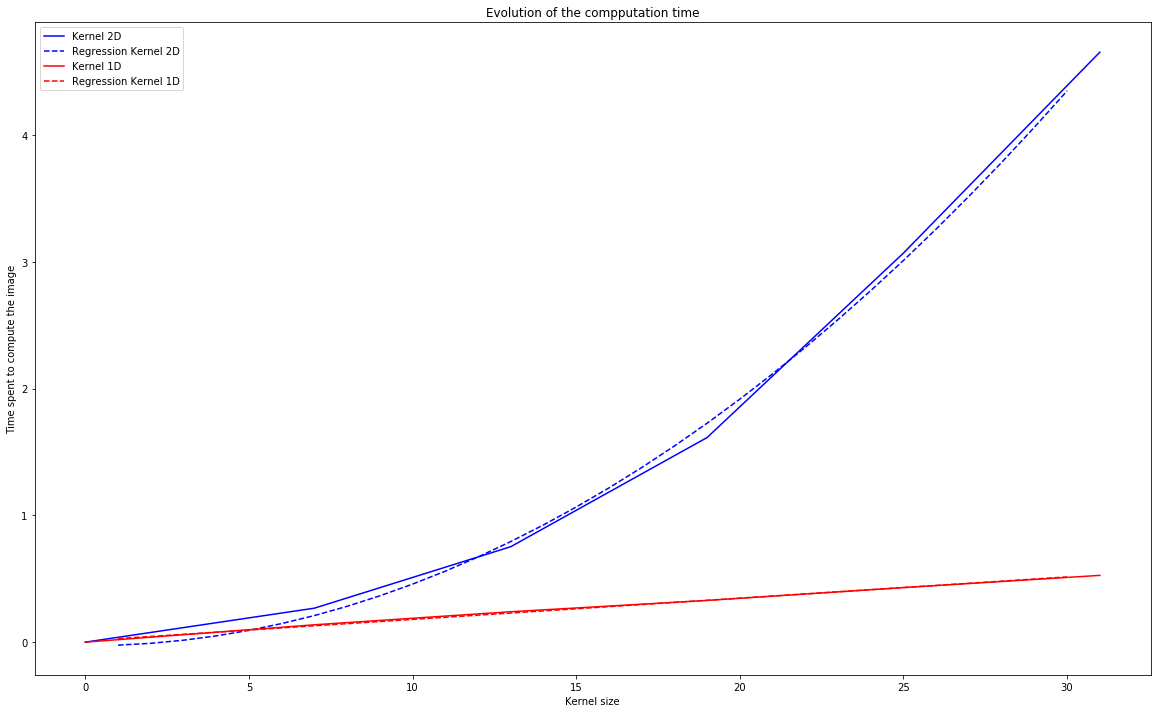

In [85]:
plt.figure(figsize = (20, 12))
plt.plot(res[:, 0], res[:, 1], label="Kernel 2D", c="b")
plt.plot(new_X, new_y, label="Regression Kernel 2D", linestyle="--", c="b")
plt.plot(res[:, 0], res[:, 2], label = "Kernel 1D", c="r")
plt.plot(new_X, new_y2, label="Regression Kernel 1D", c="r", linestyle="--")
plt.legend()
plt.title("Evolution of the computation time")
plt.ylabel("Time spent to compute the image")
plt.xlabel("Kernel size")
plt.show()

We definitely succeed to convert the convolution from $ O(n^2) $ to $ O(n) $

### Complexity related to the image Size

As we still have to pass throught each picel of the image, we can assume that the complexity remain $ O(n^2) $ related to the image size but we can still have a look.

In [101]:
sample = 6
res = np.zeros(shape=(sample, 3))
for i, factor in enumerate([0.1, 0.3, 0.5, 0.75, 1.0, 1.25]):
    img_bench = read_image("M35.jpg", factor)
    print("Pixels : {}".format(np.prod(img_bench.shape)))
    kernel_2d = gaussian_kernel_2d(3)
    kernel_1d = gaussian_kernel_1d(3)
    a, b = bench(img_bench)
    res[i] = [np.prod(img_bench.shape), a, b]

Pixels : 79200
Elapsed: 0.063s
Elapsed: 0.013s
Pixels : 712800
Elapsed: 0.574s
Elapsed: 0.117s
Pixels : 1983000
Elapsed: 1.590s
Elapsed: 0.327s
Pixels : 4464000
Elapsed: 3.638s
Elapsed: 0.781s
Pixels : 7938000
Elapsed: 6.440s
Elapsed: 1.326s
Pixels : 12397500
Elapsed: 9.982s
Elapsed: 2.039s


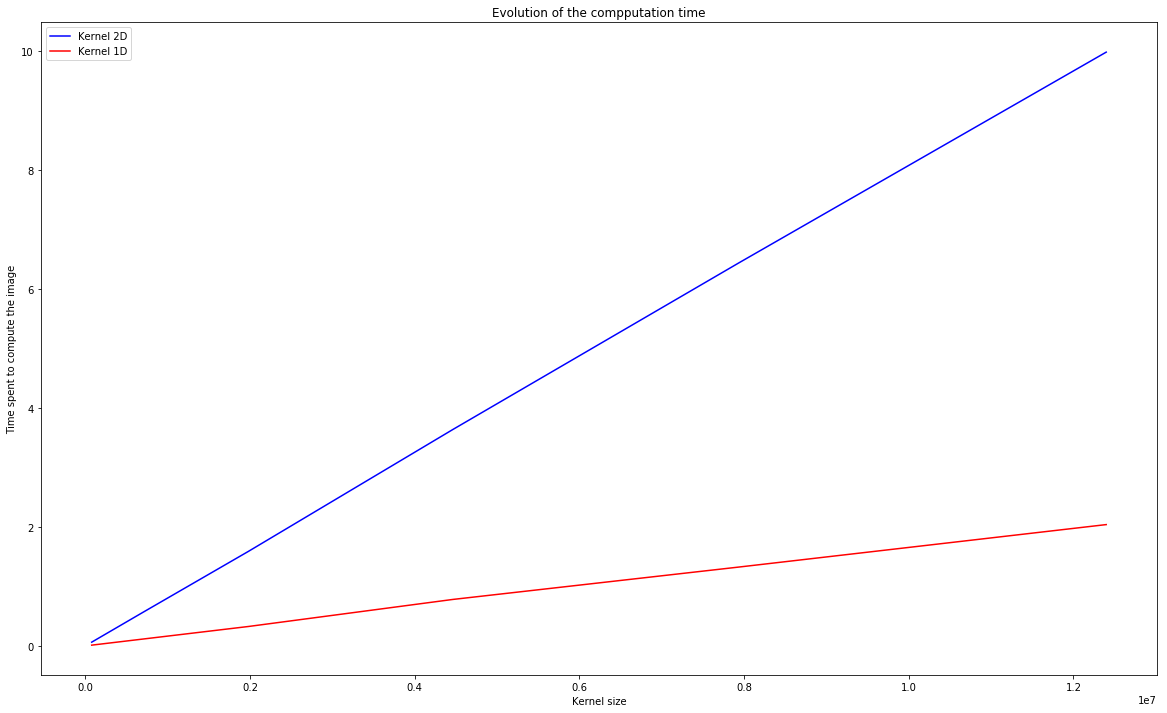

In [102]:
plt.figure(figsize = (20, 12))
plt.plot(res[:, 0], res[:, 1], label="Kernel 2D", c="b")
plt.plot(res[:, 0], res[:, 2], label = "Kernel 1D", c="r")
plt.legend()
plt.title("Evolution of the compputation time")
plt.ylabel("Time spent to compute the image")
plt.xlabel("Number of pixels")
plt.show()

We can see that we are linear related to the number of pixels (which means quadratic related to the image size). This was predictable but now we can easily see that the method of 1D filter is 5x faster in the case of a filter of size (19 x 19).

Now let's move to a more complex example with Bokeh's filter.

# Bokeh Filter

The bokeh filter is used quite often to create a lens effect on images. The base filter to do so is a simple circular filter. The shape of the filter will modify the outcome, if the filter is a triangle, the bokeh effect will be triangular. 

The problem of this filter is that it requires a big kernel size (often > 50 px). As a result it's quite slow. If you need to apply this filter in a video game, you won't be able to have a game running normally. They often cheat with a Gaussian filter. The Unreal Engine decided to use another approach. They decomposed this filter in 2 linear filters by using FFT. The filter is a sum of filters combined at the end. I don't have the complete knowledge of this method so I just reapplied values and method from Mike's code.

In [3]:
def gamma_exposure(img, gamma):
    '''increase the exposure of an image with a power gamma'''
    np.power(img, gamma, out=img)

def gamma_exposure_inverse(img, gamma):
    '''decrease the exposure of an image with a power gamma'''
    np.clip(img, 0, None, out=img)
    np.power(img, 1.0/gamma, out=img)
    
def get_parameters(component_count = 2):
    '''
    Obtain specific parameters and scale for a given component count
    
    Scales parameter bring the size of the below components to roughly the specified radius
    Kernel parameters a, b, A, B are drawn from <http://yehar.com/blog/?p=1495>
    '''
    kernel_scales = [1.4, 1.2, 1.2, 1.2, 1.2, 1.2]

    kernel_params = [
                    # 1-component
                    [[0.862325, 1.624835, 0.767583, 1.862321]],          

                    # 2-components
                    [[0.886528, 5.268909, 0.411259, -0.548794],
                    [1.960518, 1.558213, 0.513282, 4.56111]],

                    # 3-components
                    [[2.17649, 5.043495, 1.621035, -2.105439],
                    [1.019306, 9.027613, -0.28086, -0.162882],
                    [2.81511, 1.597273, -0.366471, 10.300301]],

                    # 4-components
                    [[4.338459, 1.553635, -5.767909, 46.164397],
                    [3.839993, 4.693183, 9.795391, -15.227561],
                    [2.791880, 8.178137, -3.048324, 0.302959],
                    [1.342190, 12.328289, 0.010001, 0.244650]],

                    # 5-components
                    [[4.892608, 1.685979, -22.356787, 85.91246],
                    [4.71187, 4.998496, 35.918936, -28.875618],
                    [4.052795, 8.244168, -13.212253, -1.578428],
                    [2.929212, 11.900859, 0.507991, 1.816328],
                    [1.512961, 16.116382, 0.138051, -0.01]],

                    # 6-components
                    [[5.143778, 2.079813, -82.326596, 111.231024],
                    [5.612426, 6.153387, 113.878661, 58.004879],
                    [5.982921, 9.802895, 39.479083, -162.028887],
                    [6.505167, 11.059237, -71.286026, 95.027069],
                    [3.869579, 14.81052, 1.405746, -3.704914],
                    [2.201904, 19.032909, -0.152784, -0.107988]]]
    
    parameter_dictionaries = [dict(zip(['a','b','A','B'], b)) for b in kernel_params[component_count-1]]
    return (parameter_dictionaries, kernel_scales[component_count-1])

def complex_kernel_1d(radius, component_count):
    '''
    Produces a complex kernel of a given radius and scale (adjusts radius to be more accurate)
    a and b are parameters of this complex kernel
    '''
    
    params, scale = get_parameters(component_count = component_count)
    
    kernel_radius = radius
    kernel_size = kernel_radius * 2 + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1., dtype=np.float32)
    ax = ax * scale / kernel_radius
    kernels = np.zeros(shape=(component_count, kernel_size), dtype=np.complex64)
    total = 0
    for i, param in enumerate(params):
        kernels[i].real = np.exp(-param["a"] * (ax**2)) * np.cos(param["b"] * (ax**2))
        kernels[i].imag = np.exp(-param["a"] * (ax**2)) * np.sin(param["b"] * (ax**2))
    
        # Normalises with respect to A*real+B*imag
        for j in range(kernel_size):
            for k in range(kernel_size):
                # Complex multiply and weighted sum
                total += param['A'] * (kernels[i,j].real * kernels[i, k].real - kernels[i,j].imag * kernels[i, k].imag)\
                        + param['B'] * (kernels[i,j].real * kernels[i, k].imag + kernels[i,j].imag * kernels[i, k].real)
        
    kernels /= np.sqrt(total)
        
    return kernels.reshape((component_count, 1, kernel_size))

def complex_kernel_2d(kernels):
    '''
    Produce a 2D kernel by self-multiplying a 1d kernel. This would be slower to use
    than the separable approach, mostly for visualisation below
    '''
    n_filter, h, w = kernels.shape
    kernels_2d = np.zeros((n_filter, w, w), dtype=np.complex64)
    for i in range(n_filter):
        kernels_2d[i] = kernels[i].T @ kernels[i]
    return kernels_2d

def final_filter(kernels_2d, params):
    '''
    Based on the number of parameters, the final filter is produce by normalizing them
    '''
    n_filter, h, w = kernels_2d.shape
    kernel = np.zeros((h, w), dtype=np.complex64)
    for i in range(n_filter):
        kernel += kernels_2d[i].real * params[i]['A'] + kernels_2d[i].imag * params[i]['B']
    return kernel.real

def perfect_filter(kernels_2d, threshold = 0.9):
    '''
    Provides the perfect filter (2D) with the same size of the one produced by 1D filters
    '''
    kernel = (kernels_2d > threshold * kernels_2d.max()).astype(int)
    return kernel/kernel.sum()

def show_kernel(kernels_2d, params, mode="1D"):
    '''
    Visualise 1D or 2D kernels components
    '''
    n_filter, h, w = kernels_2d.shape
    
    if mode == "1D":
        kernel_sum = np.zeros(w, dtype=np.complex64)
        fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(20,12))
        for i in range(n_filter):
            slice_ = kernels_2d[i, w//2 + 1, :]
            ax.plot(slice_.real, label = "Real part - filter {}".format(i+1))
            ax2.plot(slice_.imag, label = "Img part - filter {}".format(i+1))
            scaled_slice = slice_.real * params[i]['A'] + slice_.imag * params[i]['B']
            kernel_sum += scaled_slice
        ax3.plot(np.array(kernel_sum), label = "Resulting 1D filter")
        
        ax.set_title("Real part")
        ax2.set_title("Img part")
        ax3.set_title("Full")
        plt.legend()
        plt.show()
    else:
        kernel_sum = np.zeros((n_filter, w, w), dtype=np.complex64)
        f, axarr = plt.subplots(n_filter+1, 3, figsize=(20,n_filter*7))
        for i in range(n_filter):
            axarr[i, 0].imshow(kernels_2d[i].real, cmap='gray', interpolation='nearest')
            axarr[i, 1].imshow(kernels_2d[i].imag, cmap='gray', interpolation='nearest')
            kernel_sum[i] = kernels_2d[i].real * params[i]['A'] + kernels_2d[i].imag * params[i]['B']
            axarr[i, 2].imshow(kernel_sum[i].real, cmap='gray', interpolation='nearest')
                    
        axarr[n_filter, 0].imshow(kernel_sum.real.sum(axis=0), cmap='gray', interpolation='nearest')
        axarr[n_filter, 1].imshow(kernel_sum.imag.sum(axis=0), cmap='gray', interpolation='nearest')
        axarr[n_filter, 2].imshow(kernel_sum.real.sum(axis=0), cmap='gray', interpolation='nearest')
        
        for ax, col in zip(axarr[0], ["Real part", "Img part", "Full"]):
            ax.set_title(col)

        rows = ["filter " + str(i+1) for i in range(n_filter)] + ["final filter"]
        for ax, row in zip(axarr[:,0], rows):
            ax.set_ylabel(row, rotation=0, size='large')
        
        plt.show()

In [4]:
radius = 50
component_count = 3

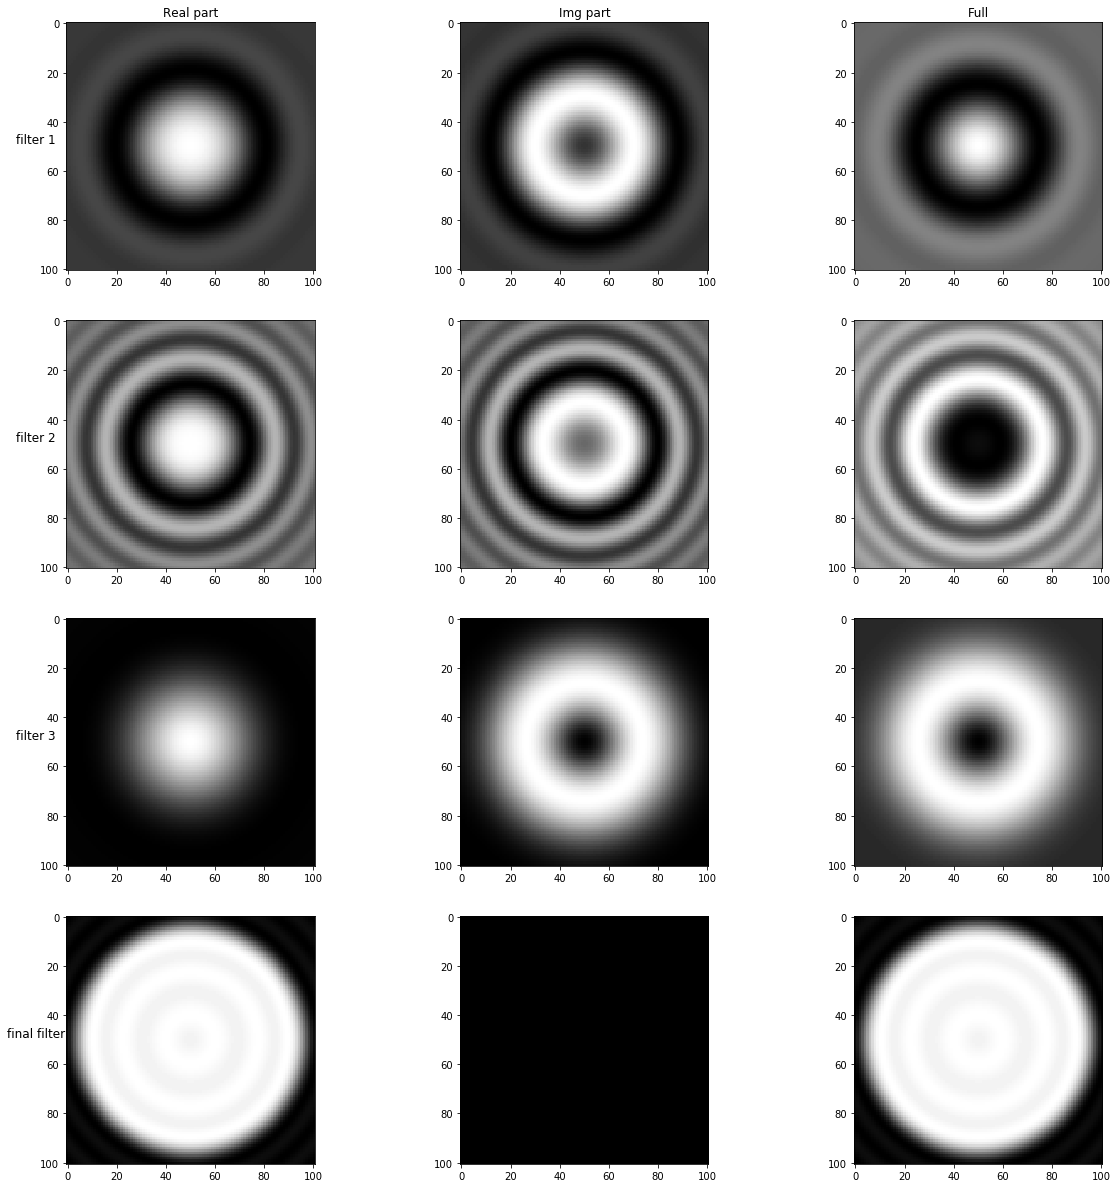

In [5]:
params, _ = get_parameters(component_count = component_count)
kernels_1d = complex_kernel_1d(radius = 50, component_count = component_count)
kernels_2d = complex_kernel_2d(kernels_1d)

show_kernel(kernels_2d, params, mode="2D")

C:\python36\envs\machine_learning\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


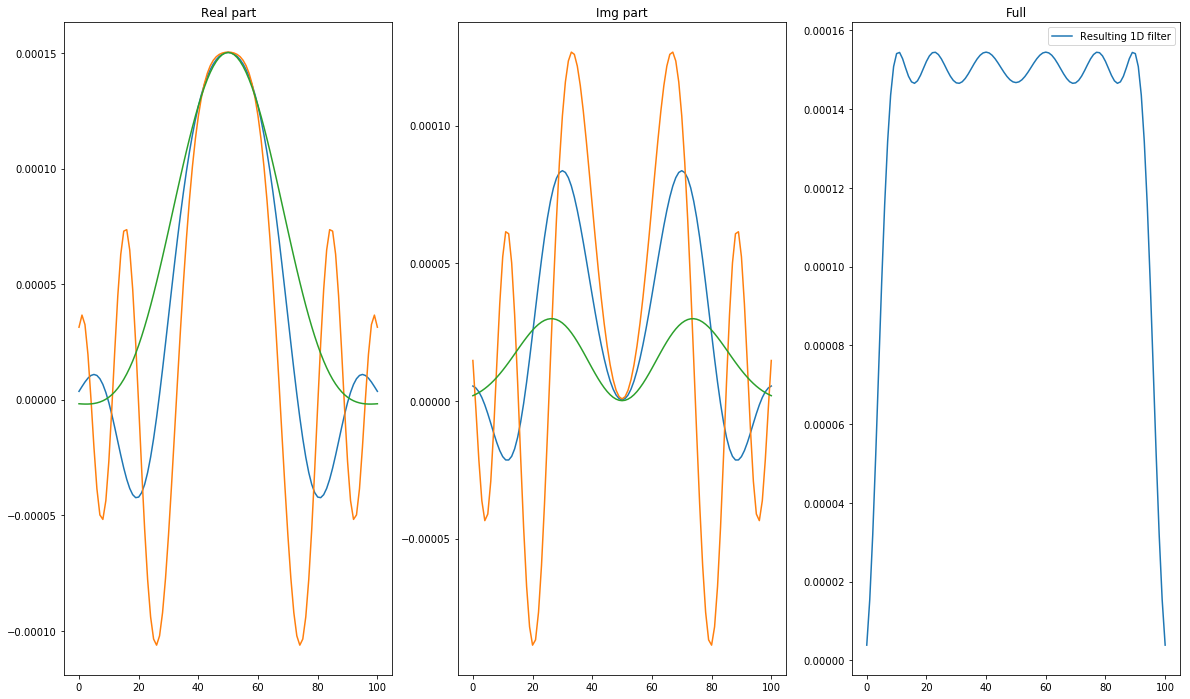

In [6]:
show_kernel(kernels_2d, params, mode="1D")

Now we are able to create a 2D filter close to a circle from $ component\_count * vector $. Let's create the perfect filter corresponding to this filter to do a comparison afterward.

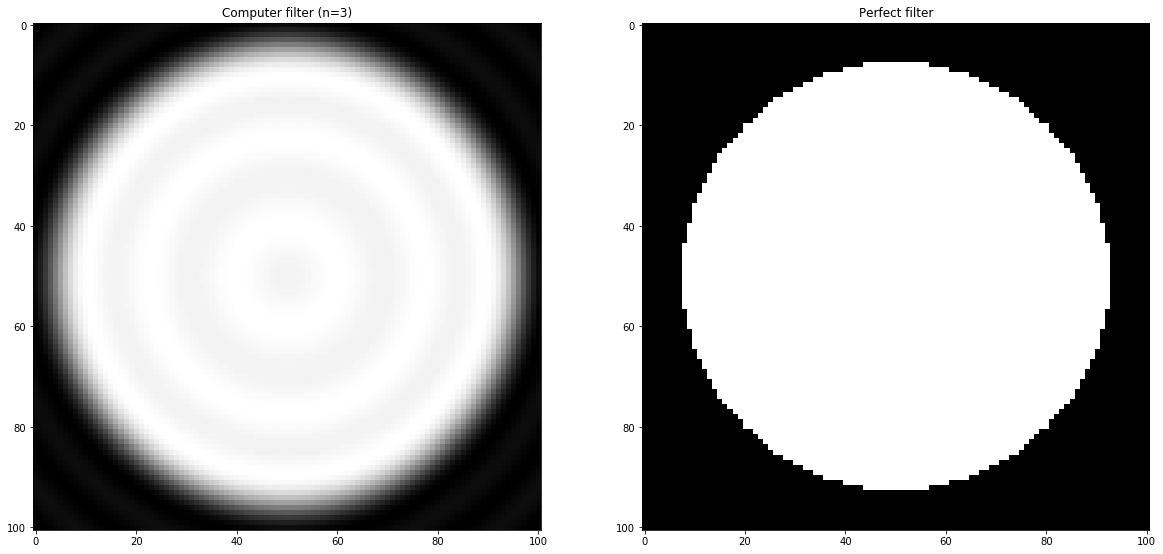

In [7]:
a = final_filter(kernels_2d, params)
b = perfect_filter(a)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20,12))
ax.imshow(a, cmap='gray', interpolation='nearest')
ax2.imshow(b, cmap='gray', interpolation='nearest')
ax.set_title("Computer filter (n={})".format(component_count))
ax2.set_title("Perfect filter")
plt.show()

We can also plot the resulting filter based on component_count. As we know from FFT, we would require an infinite sum of vectors to reach the perfect filter. To be faster, we still need to minimize the number of components so let's have a look at the evolution of the filter

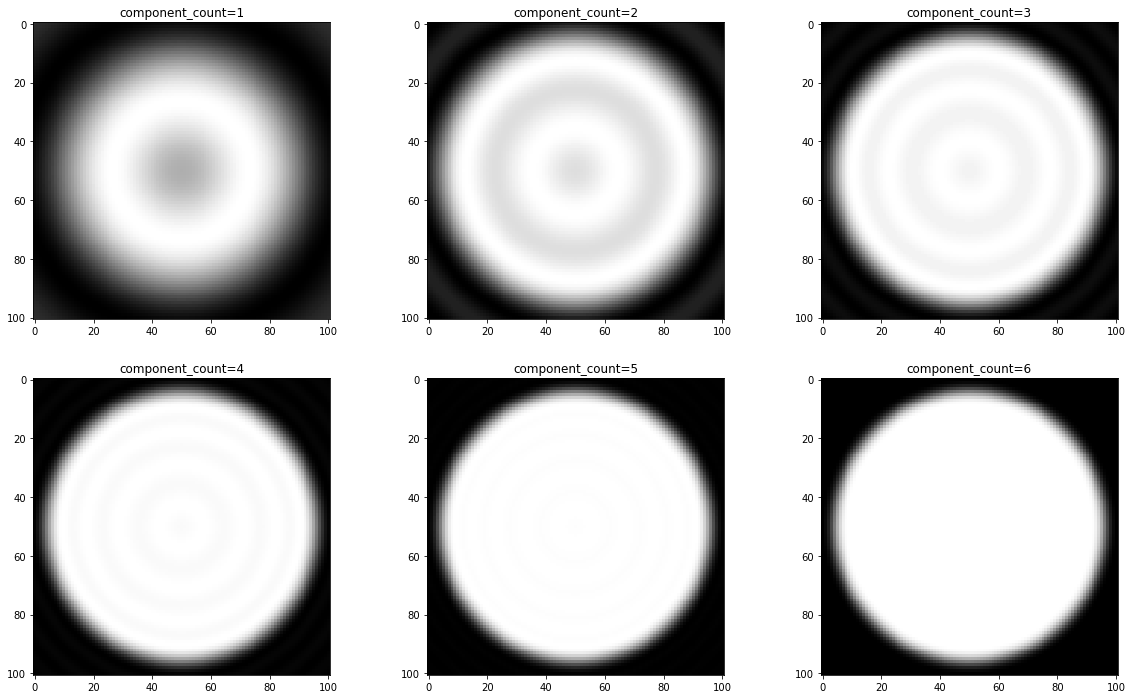

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(20,12))
for i in range(6): # we have 6 components max
    params, _ = get_parameters(component_count = i+1)
    kernels_1d = complex_kernel_1d(radius = 50, component_count = i+1)
    kernels_2d = complex_kernel_2d(kernels_1d)
    kernels_2d_final = final_filter(kernels_2d, params)
    axes[i//3, i%3].imshow(kernels_2d_final, cmap='gray', interpolation='nearest')
    axes[i//3, i%3].set_title("component_count={}".format(i+1))
plt.show()

At first sight, we can see the case with 3 components is quite clean, we could use it in a game engine. Of course the more components is better but we have to keep in memory that we will have 2 convolutions per components and also we will have to store those resulting images in memory to combined them afterward. For this benchmark, we will try all sizes on the same image as previously used but smaller. We will also use a smaller filter (30 instead of 50 used previously)

In [21]:
def process_approx(image, exposure_gamma, component_count):
    image = image.copy()
    output = np.zeros([component_count] + list(image.shape), dtype=np.complex64)  # will be converted at the end to an image shape
    
    params, _ = get_parameters(component_count = component_count)
    kernels_1d = complex_kernel_1d(radius = 30, component_count = component_count)

    # Add exposure
    gamma_exposure(image, exposure_gamma)
    
    t0 = time.perf_counter()

    # Nx1 -> 1xN convolution
    for l, filter1d, param in zip(range(component_count), kernels_1d, params):
        channels = []
        for i in range(3):
            inter = scipy.signal.convolve2d(image[:, :, i], filter1d, mode="same")
            output[l, :, :, i] = scipy.signal.convolve2d(inter, filter1d.T, mode="same")

    for i in range(component_count):
        output[i] = output[i].real * params[i]["A"] + output[i].imag * params[i]["B"]

    output = output.sum(axis=0).real

    e = time.perf_counter() - t0

    # Reverse exposure
    gamma_exposure_inverse(output, exposure_gamma)

    # Avoid out of range values - generally this only occurs with small negatives
    # due to imperfect complex kernels
    return e, np.clip(output, 0, 1)

def process_perfect(image, exposure_gamma):
    image = image.copy()
    output = np.zeros(image.shape, dtype=np.float32)
    
    params, _ = get_parameters(component_count = 6)
    kernels_1d = complex_kernel_1d(radius = 30, component_count = 6)
    kernels_2d = complex_kernel_2d(kernels_1d)
    kernel_2d_final = final_filter(kernels_2d, params)
    kernels_2d_perfect = perfect_filter(kernel_2d_final, threshold=0.9)
    
    # Add exposure
    gamma_exposure(image, exposure_gamma)

    t0 = time.perf_counter()

    # NxN convolution
    for i in range(3):
        output[:, :, i] = scipy.signal.convolve2d(image[:, :, i], kernels_2d_perfect, mode="same")

    e = time.perf_counter() - t0

    # Reverse exposure
    gamma_exposure_inverse(output, exposure_gamma)

    # Avoid out of range values - generally this only occurs with small negatives
    # due to imperfect complex kernels
    return e, np.clip(output, 0, 1)

In [22]:
exposure_gamma = 5
img = read_image("M35.jpg", resize_factor=0.3)

t = []
out = []
for i in range(1, 7):
    t_, im_ = process_approx(img, exposure_gamma, i)
    t.append(t_)
    out.append(im_)
    
t_, im_ = process_perfect(img, exposure_gamma)
t.append(t_)
out.append(im_)

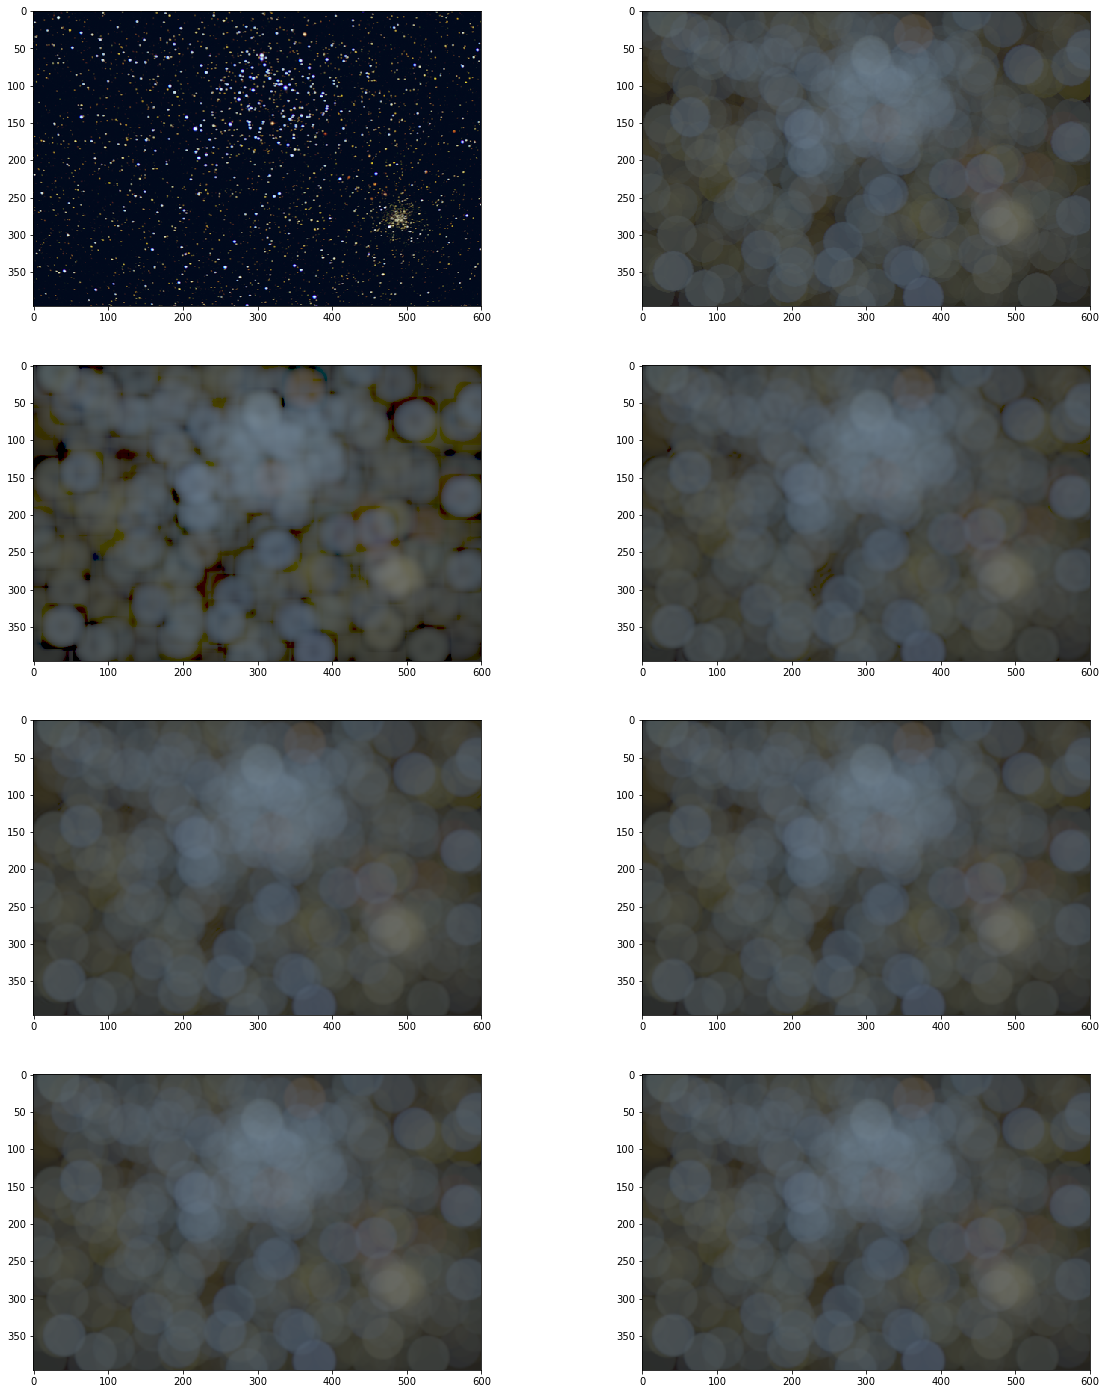

In [23]:
titles = ["Result with {} components".format(i) for i in range(1, 7)]
fig, axes = plt.subplots(4, 2, figsize=(20,25))
axes[0, 0].imshow(img)
axes[0, 1].imshow(out[6])
axes[1, 0].imshow(out[0])
axes[1, 1].imshow(out[1])
axes[2, 0].imshow(out[2])
axes[2, 1].imshow(out[3])
axes[3, 0].imshow(out[4])
axes[3, 1].imshow(out[5])
plt.show()

As we did previously, we can check the entropy vs the perfect filtered image. We can after that, plot it vs the time spet to render the time.

In [44]:
reference = out[-1].flatten()
entropies = [entropy(x.flatten(), reference) for x in out]
texts = ["{} comps".format(i+1) for i in range(6)] + ["Perfect filter"]

In [48]:
entropies

[0.020942293,
 0.001173101,
 0.00079806044,
 0.0007508526,
 0.00073762547,
 0.0007242481,
 0.0]

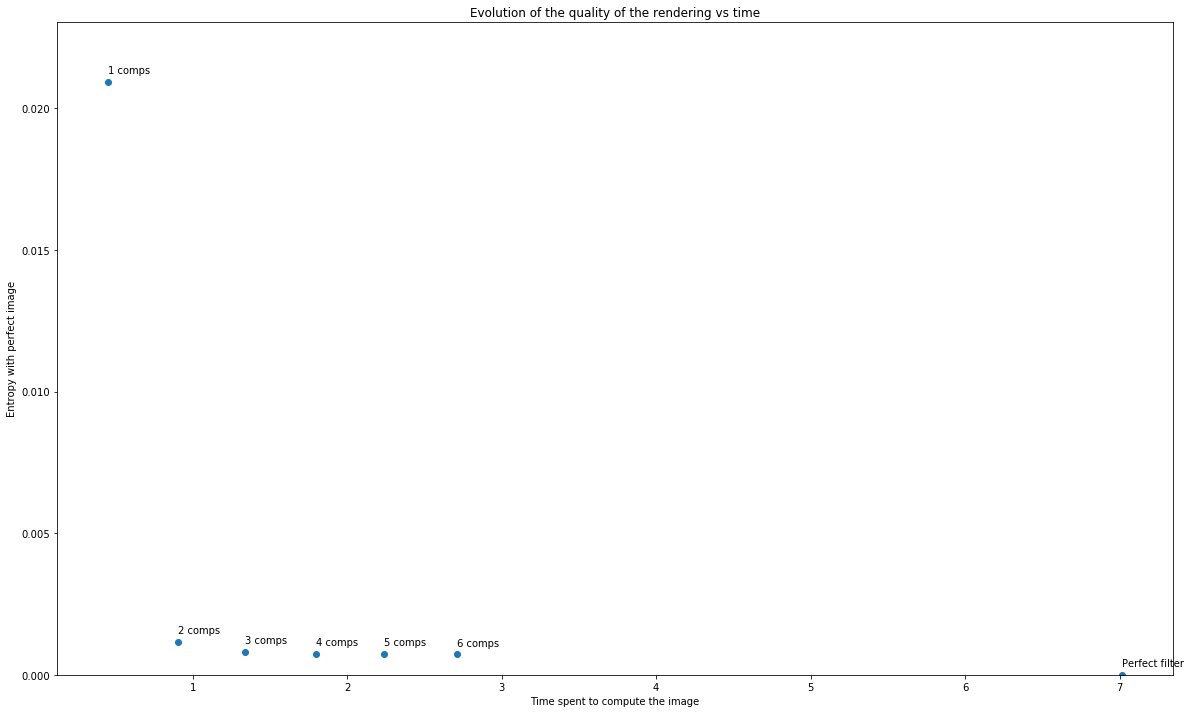

In [47]:
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(t, entropies)
plt.ylim(0, max(entropies)*1.1)
for i, txt in enumerate(texts):
    ax.annotate(txt, (t[i], entropies[i]+0.0003))
ax.set_ylabel("Entropy with perfect image")
ax.set_xlabel("Time spent to compute the image")
ax.set_title("Evolution of the quality of the rendering vs time")
plt.show()

We can now say that the best ration quality/time is with 3 components. It's around 5 times faster and the quality is not very worse than 6 components (entropy of 8e-4 compare to 7e-4 at 6 components).

# Conclusion

In this notebook, we explored a way to highly improve convolution's performances by using filter decomposition. Unfortunately, all filters cannot be decomposed but in some cases, it worse it. We saw that it's able to convert the convolution step from a complexity $ O(n^2) $ related to kernel size to $ O(n) $. For big filters used in imaged processing, the benefits is highly import (in our case, we measure a gain of 5x for a kernel of 30).